In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
from data_analysis import Dataset

In [3]:
run_label = '20210707' ## Change this to look at different runs
d = Dataset(run_label=run_label, gases=['O2', 'CO2'])

0 2279
1 3427
2 4508
3 7583
0 2314
1 3418
2 4447
3 7565


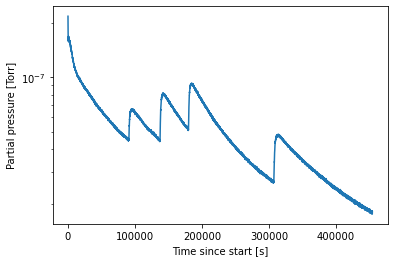

In [4]:
d.GetData()
d.FindPeaks()
d.GetRanges()
d.PlotSingleGas('CO2')

O2
CO2


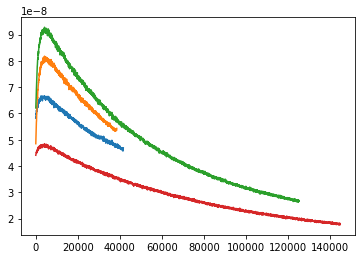

In [5]:
for gas in d.gases:
    print(gas)
    if gas =='O2':
        continue
    for fitrange in d.range[gas]:
        time_offset = np.array(d.data[gas]['exp_time'])[fitrange[0]]
        xdata = np.array(d.data[gas]['exp_time'])[fitrange[0]:fitrange[1]] - time_offset
        ydata = np.array(d.data[gas]['pressure'])[fitrange[0]:fitrange[1]]
        plt.plot(xdata,ydata)

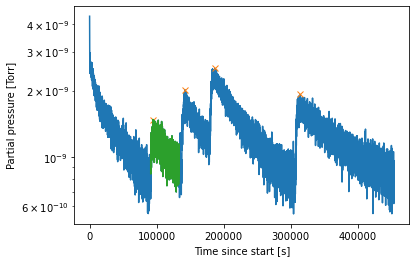

In [17]:
gas = 'O2'
d.PlotSingleGas(gas)
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas]], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas]], 'x')
plt.plot(np.array(d.data[gas]['exp_time'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         np.array(d.data[gas]['pressure'])[d.peak_indices[gas][0]-80:d.peak_indices[gas][1]-200], 
         ls='-')